In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# load the dataloader
from torch.utils.data import DataLoader

In [2]:
# import dataset 
import seaborn as sns
iris = sns.load_dataset('iris')

In [3]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [4]:
# splitting the data into training and testing splits
train_data, test_data, train_labels, test_labels = train_test_split(data, labels,test_size = 0.2)

# train tensor dataset
train_dataset = TensorDataset(train_data, train_labels)

# test tensor dataset
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0] )


In [5]:
# a function that creates an ann model

def createAnnModel():

      # model architecture
    ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )
    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005)

    return ANNiris,lossfun,optimizer

In [6]:
tmpmodel = createAnnModel()[0]

# print(tmpmodel)

for i,j in tmpmodel.named_parameters():
    print(i,j.numel())



0.weight 256
0.bias 64
2.weight 4096
2.bias 64
4.weight 192
4.bias 3


In [26]:
# train the model
numepochs = 1000

def trainTheModel(L1lambda):

    trainAcc = []
    testAcc = []
    losses = []


    nweights = 0
    for pname, weight in ANNiris.named_parameters():
        
        if 'bias' not in pname:
            nweights = nweights + weight.numel()

    
    for epochi in range(numepochs):

        batchAcc  = []
        batchLoss = []

        # loop over training epochs 
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat, y)


            # add L1 term 
            L1_term = torch.tensor(0., requires_grad = True)

            # sum up all abs(weights)

            for pname, weight in ANNiris.named_parameters():
                if 'bias' not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))

            # add to loss term
            loss = loss + L1lambda*L1_term/nweights

            # back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute the training accuracy
            batchAcc.append(100*torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item())
            batchLoss.append( loss.item() )

        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        X,y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X), axis = 1)
        testAcc.append(100*torch.mean((predlabels==y).float()).item())
    
    return trainAcc,testAcc,losses


        



In [27]:
# create a model
ANNiris,lossfun,optimizer = createAnnModel()

# train the model
L1lambda = .001
trainAcc,testAcc,losses = trainTheModel(L1lambda)

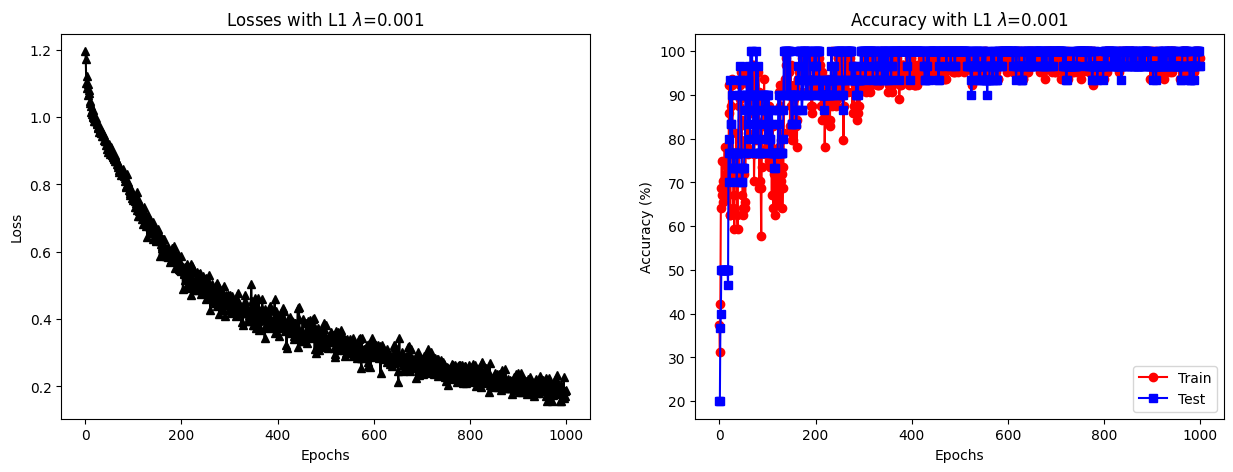

In [28]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [29]:
# create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

In [31]:
# range of L1 regularization amounts
L1lambda = np.linspace(0,.005,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(L1lambda)))
accuracyResultsTest  = np.zeros((numepochs,len(L1lambda)))


# loop over batch sizes
for li in range(len(L1lambda)):

  # create and train a model
  ANNiris,lossfun,optimizer = createAnnModel()
  trainAcc,testAcc,losses = trainTheModel(L1lambda[li])

  # store data
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li]  = smooth(testAcc,10)

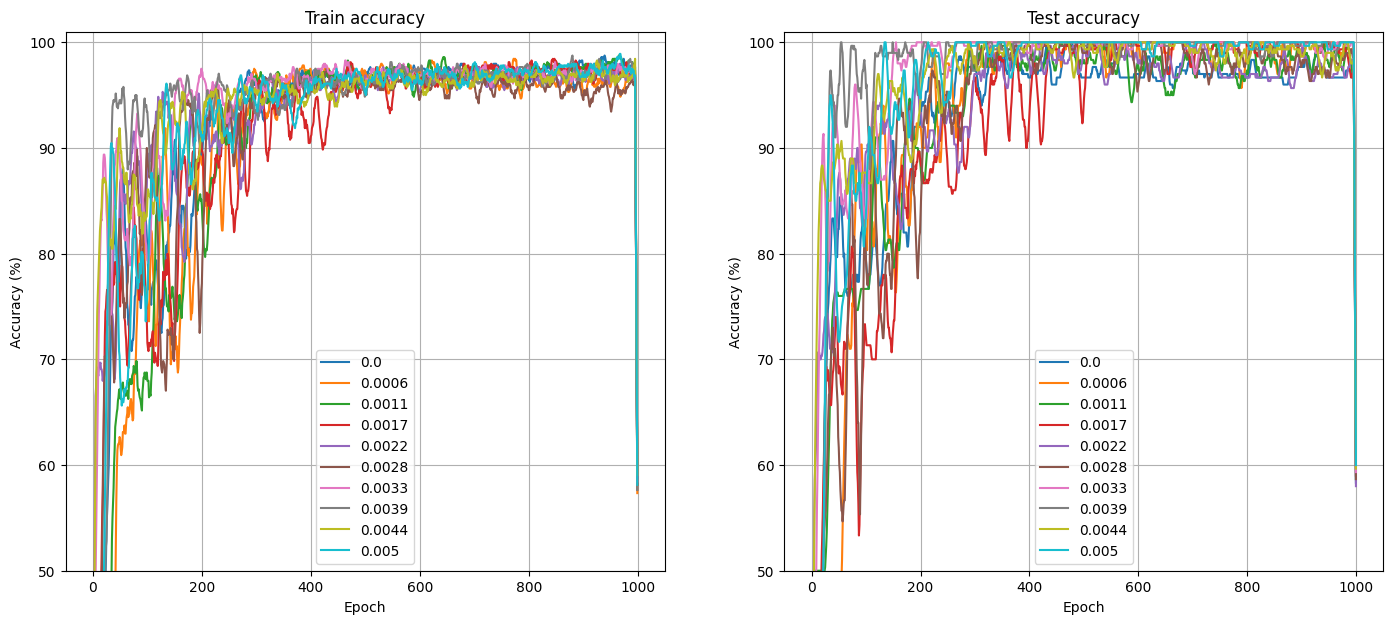

In [32]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,4) for i in L1lambda]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

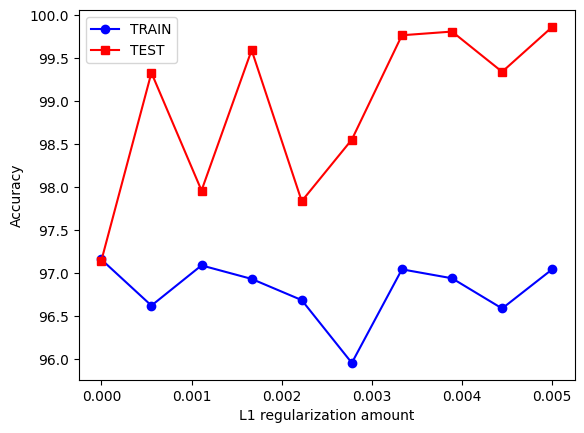

In [33]:
# show average accuracy by L1 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(L1lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L1lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()